## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import glob
import zipfile

import pathlib
%matplotlib inline

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, UpSampling2D, Input, Flatten
#from keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler
from keras import Model, Sequential
from keras.layers import Dense, Dropout
# from sklearn.model_selection import train_test_split
from keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Extracting dataset.zip file

In [2]:
!gdown 1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /content/dataset.zip
100% 1.13G/1.13G [00:17<00:00, 66.2MB/s]


In [3]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/val/no/531.npy  
  inflating: dataset/val/no/257.npy  
  inflating: dataset/val/no/243.npy  
  inflating: dataset/val/no/525.npy  
  inflating: dataset/val/no/1099.npy  
  inflating: dataset/val/no/1927.npy  
  inflating: dataset/val/no/1933.npy  
  inflating: dataset/val/no/519.npy  
  inflating: dataset/val/no/1066.npy  
  inflating: dataset/val/no/1700.npy  
  inflating: dataset/val/no/294.npy  
  inflating: dataset/val/no/2209.npy  
  inflating: dataset/val/no/280.npy  
  inflating: dataset/val/no/1714.npy  
  inflating: dataset/val/no/1072.npy  
  inflating: dataset/val/no/2235.npy  
  inflating: dataset/val/no/1728.npy  
  inflating: dataset/val/no/2221.npy  
  inflating: dataset/val/no/733.npy  
  inflating: dataset/val/no/727.npy  
  inflating: dataset/val/no/1502.npy  
  inflating: dataset/val/no/1264.npy  
  inflating: dataset/val/no/928.npy  
  inflating: dataset/val/no/1270.npy  
  inflating: dataset/va

## Plotting 1 image from each of No, Sphere and Vort classes for comparison

**Setting dataset path** 


In [4]:
data_path = '/content/dataset/'

In [5]:
file1 = np.load(data_path + 'train/no/1.npy')
file2 = np.load(data_path + 'train/sphere/1.npy')
file3 = np.load(data_path + 'train/vort/1.npy')

In [6]:
print(file1.shape)
print(file2.shape)
print(file3.shape)

(1, 150, 150)
(1, 150, 150)
(1, 150, 150)


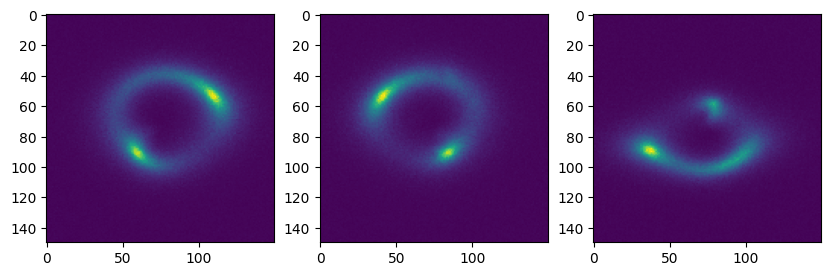

In [7]:
plt.figure(figsize = (10, 15))
plt.subplot(1, 3, 1)
plt.imshow(file1[0])

plt.subplot(1, 3, 2)
plt.imshow(file2[0])

plt.subplot(1, 3, 3)
plt.imshow(file3[0])

## Creating Customized Data Generator for training

In [8]:
classes = ['no', 'sphere', 'vort']

In [9]:
ohc = OneHotEncoder()

In [10]:
X = [['no', 1], ['sphere', 3]]
a = ohc.fit_transform(X)

In [11]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, path, classes, batch_size, shuffle = False):
        
        assert (batch_size%len(classes))==0, "no. of classes"

        self.classes = classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        #Creating path dictionary
        p = pathlib.Path(path)
        self.paths = {}
        for c in classes:
            self.paths[c] = list(p.glob(c + '/*'))
            
        self.n = len(self.paths[classes[0]])*len(classes)           
        
    def on_epoch_end(self):
        if self.shuffle:
            for c in self.classes:
                random.shuffle(self.paths[c])
    
    def __getitem__(self, index):
        sub_batch_size = int(self.batch_size/len(self.classes))
        batches_list = []
        labels_list = []
        for c in range(len(self.classes)):
            for i in range(sub_batch_size):
                batches_list.append(np.load(self.paths[self.classes[c]][i+index*sub_batch_size]))
                labels_list.append(c)
        X = np.array(batches_list)
        X = np.squeeze(X, axis = 1)
        X = np.expand_dims(X, axis = -1)
        y = tf.keras.utils.to_categorical(np.array(labels_list))
        #X, y = tf.random.shuffle((X, y))      
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [12]:
datag_train = CustomDataGen(path = data_path + 'train/', classes = classes, batch_size = 120, shuffle = True)
datag_val = CustomDataGen(path = data_path + 'val/', classes = classes, batch_size = 120, shuffle = True)

In [13]:
datag_train[0][0].shape

(120, 150, 150, 1)

In [14]:
datag_val[0][0].shape

(120, 150, 150, 1)

## Creating CNN architecture for classification and training

In [15]:
input_img = Input(shape=(150, 150, 1))
x = Conv2D(4, (16, 16), activation='relu', padding='valid')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(3, activation = 'softmax')(x)

model = Model(input_img, x)


model_earlystop = EarlyStopping(patience = 5, min_delta = 0.001, monitor = 'val_acc')

path = 'model_checkpoint/checkpoint_{epoch:02d}';
model_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 135, 135, 4)       1028      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 68, 68, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 8)         2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        3216  

**Training**

In [16]:
history = model.fit(datag_train, validation_data = datag_val, epochs = 30)

Epoch 1/30
250/250 [==============================] - 98s 333ms/step - loss: 0.6373 - acc: 0.3404 - val_loss: 0.6364 - val_acc: 0.3491
Epoch 2/30
250/250 [==============================] - 79s 314ms/step - loss: 0.6363 - acc: 0.3412 - val_loss: 0.6357 - val_acc: 0.3567
Epoch 3/30
250/250 [==============================] - 78s 313ms/step - loss: 0.6349 - acc: 0.3539 - val_loss: 0.6321 - val_acc: 0.3566
Epoch 4/30
250/250 [==============================] - 79s 317ms/step - loss: 0.6183 - acc: 0.4120 - val_loss: 0.6177 - val_acc: 0.4599
Epoch 5/30
250/250 [==============================] - 78s 310ms/step - loss: 0.5867 - acc: 0.4797 - val_loss: 0.5698 - val_acc: 0.5103
Epoch 6/30
250/250 [==============================] - 79s 316ms/step - loss: 0.5576 - acc: 0.5265 - val_loss: 0.5455 - val_acc: 0.5450
Epoch 7/30
250/250 [==============================] - 76s 304ms/step - loss: 0.5362 - acc: 0.5584 - val_loss: 0.5368 - val_acc: 0.5528
Epoch 8/30
250/250 [==============================] - 7

### Plotting Training acc vs loss

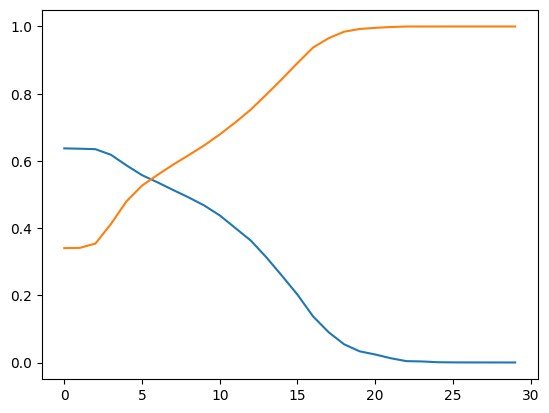

In [17]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

### Plotting Validation acc vs loss

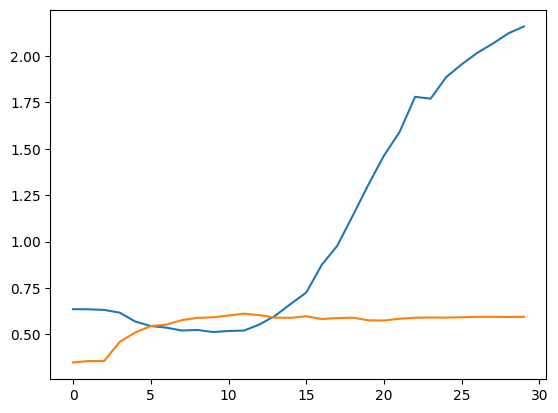

In [18]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])

In [19]:
filepath = '/content/model/'

In [20]:
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

### Saving the trained model

In [21]:
import os
checkpoint_dir = os.path.dirname(path)

In [22]:
checkpoint_dir

'model_checkpoint'

In [23]:
#os.listdir(checkpoint_dir)

FileNotFoundError: ignored

### Loading the Trained model

In [26]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 92%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/saved_model.pb (deflated 88%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 64%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 26%)


In [24]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [25]:
model.load_weights(latest)

AttributeError: ignored

In [ ]:
# model = tf.keras.models.load_model(
#     filepath, custom_objects=None, compile=True, options=None
# )

## Checking performance on Validation data

### No labelled data

In [ ]:
import time

start = time.time()

images_no = np.zeros((2500, 150, 150))
for i in range(2500):
    img = np.load(data_path + 'val/no/' + str(i + 1) + '.npy')
    img = np.squeeze(img, axis = 0)
    images_no[i] = img

print(images[0])
end = time.time()
print(end - start)

### Sphere labelled data

In [ ]:
import time

start = time.time()

images_sphere = np.zeros((2500, 150, 150))
for i in range(2500):
    img = np.load(data_path + 'val/sphere/' + str(i + 1) + '.npy')
    img = np.squeeze(img, axis = 0)
    images_sphere[i] = img
#     print(i)

print(images_sphere[0])
end = time.time()
print(end - start)

In [ ]:
images_sphere[0]

### Vort labelled data 

In [ ]:
import time

start = time.time()

images_vort = np.zeros((2500, 150, 150))
for i in range(2500):
    img = np.load(data_path + 'val/vort/' + str(i + 1) + '.npy')
    img = np.squeeze(img, axis = 0)
    images_vort[i] = img
#     print(i)

print(images_vort[0])
end = time.time()
print(end - start)

In [ ]:
print(images_vort[0])

In [ ]:
images_no = np.expand_dims(images_no, axis = -1)
images_sphere = np.expand_dims(images_sphere, axis = -1)
images_vort = np.expand_dims(images_vort, axis = -1)

In [ ]:
print(images_no.shape)
print(images_sphere.shape)
print(images_vort.shape)

In [ ]:
# images_no = np.squeeze(images_no, axis = -1)

In [ ]:
images_data = np.concatenate([images_no, images_sphere, images_vort], axis = 0)

In [ ]:
print(images_data.shape)

In [ ]:
labels_no = np.zeros((2500, 1))
labels_sphere = np.ones((2500, 1))
labels_vort = 2*np.ones((2500, 1))

labels = np.concatenate([labels_no, labels_sphere, labels_vort], axis = 0)

In [ ]:
print(labels.shape)

labels = labels.astype(int)

In [ ]:
labels = np.squeeze(labels, axis = -1)

In [ ]:
labels

In [ ]:
res = np.zeros((labels.size, labels.max() + 1))
res[np.arange(labels.size), labels] = 1

In [ ]:
print(res.shape)
res

In [ ]:
model.evaluate(datag_val)

In [ ]:
datag_val[1][1].shape

In [ ]:
images_data.shape

In [ ]:
y_pred.shape

In [ ]:
res.shape

In [ ]:
ypred = model.predict(images_data)
ypred = ypred.argmax(axis=-1)
print(ypred.shape)
print(ypred)

ytrain = res.argmax(axis=-1)
print(ytrain.shape)
print(ytrain)

## Plotting final ROC curve for Validation data and calculating AUC Score

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['no', 'sphere', 'vort']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()